In [ ]:
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle competitions download -c cassava-disease

100% 2.30G/2.30G [01:44<00:00, 24.3MB/s]
100% 2.30G/2.30G [01:44<00:00, 23.6MB/s]


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input


# Load VGG16 with pre-trained weights, excluding the top classification layers
base_model = VGG16(weights='imagenet',
                    include_top=False,
                    input_shape=(128, 128, 3))


# Freeze the pre-trained layers
base_model.trainable = False

In [ ]:
model = keras.Sequential([
    base_model,
    # Add new classification layers
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')  # 5 classes for your dataset
])


In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Display Model Summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1024)                │       8,389,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,637,829 (90.17 MB)

 Trainable params: 8,920,069 (34.03 MB)

 Non-trainable params: 14,717,760 (56.14 MB)

In [ ]:
# unzip dataset
import zipfile
import glob
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
if not os.path.exists('cassava-disease.zip'):
    print("Error: cassava-disease.zip not found!")
else:
    print("Found cassava-disease.zip")

Found cassava-disease.zip


In [ ]:
print("\nExtracting files...")
with zipfile.ZipFile('cassava-disease.zip', 'r') as zip_ref:
  zip_ref.extractall('dataset')

print("Extracting train.zip...")
with zipfile.ZipFile('dataset/train.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset/train')



Extracting files...
Extracting train.zip...


In [ ]:
def load_preprocess_images(image_path, size=(128,128)):
  img = load_img(image_path, target_size=size)
  img_array = img_to_array(img)
  new_img_array = img_array / 255.0 # normalize pixel values return new_img_array

In [ ]:
# grab images
class_map = {
    'cbb': 0,
    'cmd': 1,
    'cbsd': 2,
    'cgm': 3,
    'healthy': 4
}

train_directory = 'dataset/train/train'
img_paths = glob.glob(os.path.join(train_directory, '*.jpg'))

# list to store images and labels
X = []
y = []

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
BATCH_SIZE = 32

def setup_data_generators(img_height, img_width):
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        validation_split=0.2
    )

    train_generator = train_datagen.flow_from_directory(
        'dataset/train/train',
        target_size=(img_height, img_width),
        batch_size=32,
        class_mode='categorical',
        subset='training'
    )

    validation_generator = train_datagen.flow_from_directory(
        'dataset/train/train',
        target_size=(img_height, img_width),
        batch_size=32,
        class_mode='categorical',
        subset='validation'
    )

    return train_generator, validation_generator

In [ ]:
def print_dataset_info():
    class_counts = {}

    # Count images in each class
    for class_name in class_map.keys():
        class_path = os.path.join(train_directory, class_name)
        if os.path.exists(class_path):
            num_images = len([f for f in os.listdir(class_path)
                            if f.endswith(('.jpg', '.jpeg', '.png'))])
            class_counts[class_name] = num_images

    print("\nDataset Information:")
    print("-" * 50)
    total_images = sum(class_counts.values())

    for class_name, count in class_counts.items():
        percentage = (count / total_images) * 100
        print(f"{class_name}: {count} images ({percentage:.2f}%)")

    print("-" * 50)
    print(f"Total images: {total_images}")


In [ ]:
try:
    train_generator, validation_generator = setup_data_generators(128,128)
    print("\nData generators created successfully!")
    print(f"Found {train_generator.samples} training samples")
    print(f"Found {validation_generator.samples} validation samples")

    # Print class indices
    print("\nClass mapping:")
    for class_name, class_idx in train_generator.class_indices.items():
        print(f"{class_name}: {class_idx}")

    # Print detailed dataset information
    print_dataset_info()

except Exception as e:
    print(f"Error setting up data generators: {str(e)}")

Found 4527 images belonging to 5 classes.
Found 1129 images belonging to 5 classes.

Data generators created successfully!
Found 4527 training samples
Found 1129 validation samples

Class mapping:
cbb: 0
cbsd: 1
cgm: 2
cmd: 3
healthy: 4

Dataset Information:
--------------------------------------------------
cbb: 466 images (8.24%)
cmd: 2658 images (46.99%)
cbsd: 1443 images (25.51%)
cgm: 773 images (13.67%)
healthy: 316 images (5.59%)
--------------------------------------------------
Total images: 5656


In [ ]:
train = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,  # You might need fewer epochs with transfer learning
    batch_size=32,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=5),
        keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=3)
    ]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 66s 382ms/step - accuracy: 0.2774 - loss: 2.4647 - val_accuracy: 0.5421 - val_loss: 1.3478 - learning_rate: 1.0000e-04
Epoch 2/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 45s 319ms/step - accuracy: 0.4283 - loss: 1.8895 - val_accuracy: 0.5872 - val_loss: 1.1973 - learning_rate: 1.0000e-04
Epoch 3/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 45s 320ms/step - accuracy: 0.4575 - loss: 1.7124 - val_accuracy: 0.6076 - val_loss: 1.1226 - learning_rate: 1.0000e-04
Epoch 4/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 49s 342ms/step - accuracy: 0.5060 - loss: 1.5842 - val_accuracy: 0.6236 - val_loss: 1.0981 - learning_rate: 1.0000e-04
Epoch 5/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 46s 323ms/step - accuracy: 0.5330 - loss: 1.4653 - val_accuracy: 0.6422 - val_loss: 1.0694 - learning_rate: 1.0000e-04
Epoch 6/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 46s 327ms/step - accuracy: 0.5296 - loss: 1.4552 - val_accuracy: 0.6554 - val_loss: 1.0405 - learning_rate: 1.0000e-04
Epoch 7/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 45s 31

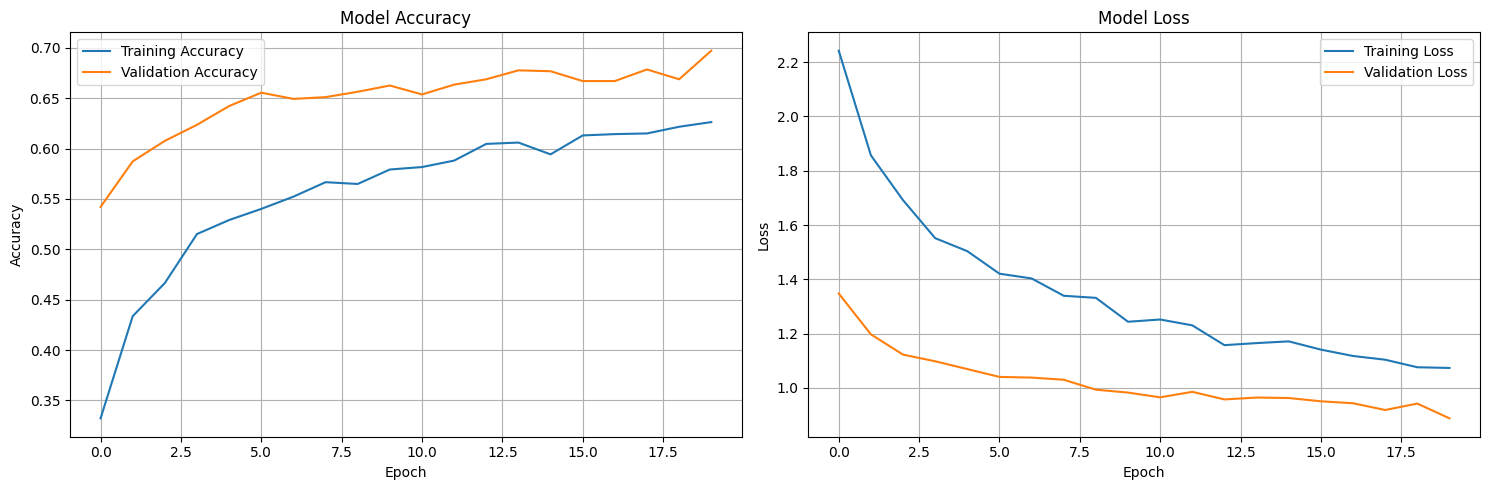

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(train):
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training & validation accuracy
    ax1.plot(train.history['accuracy'], label='Training Accuracy')
    ax1.plot(train.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Plot training & validation loss
    ax2.plot(train.history['loss'], label='Training Loss')
    ax2.plot(train.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(train)

In [ ]:
!kaggle competitions download -c dogs-vs-cats

100% 811M/812M [00:36<00:00, 24.2MB/s]
100% 812M/812M [00:36<00:00, 23.3MB/s]


In [ ]:

if not os.path.exists('dogs-vs-cats.zip'):
    print("Error: dogs-vs-cats.zip not found!")
else:
    print("Found dogs-vs-cats.zip")

Found dogs-vs-cats.zip


In [ ]:
print("\nExtracting files...")
with zipfile.ZipFile('dogs-vs-cats.zip', 'r') as zip_ref:
  zip_ref.extractall('dataset2')

print("Extracting train.zip...")
with zipfile.ZipFile('dataset2/train.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset2/train')


Extracting files...
Extracting train.zip...


In [ ]:
train_directory = 'dataset2/train/train'
img_paths = glob.glob(os.path.join(train_directory, '*.jpg'))

# list to store images and labels
X = []
y = []

In [ ]:
for i, img_path in enumerate(img_paths):
    if i % 1000 == 0:  # Print progress every 1000 images
        print(f"Processing image {i}/{len(img_paths)}")

    try:
        # Get image label from filename
        label = 1 if 'dog' in os.path.basename(img_path).lower() else 0

        # Load and preprocess image
        img = load_img(img_path, target_size=(32, 32))
        img_array = img_to_array(img)
        img_array = img_array / 255.0

        # Append to lists
        X.append(img_array)
        y.append(label)

    except Exception as e:
        print(f"Error processing {img_path}: {str(e)}")

Processing image 0/25000
Processing image 1000/25000
Processing image 2000/25000
Processing image 3000/25000
Processing image 4000/25000
Processing image 5000/25000
Processing image 6000/25000
Processing image 7000/25000
Processing image 8000/25000
Processing image 9000/25000
Processing image 10000/25000
Processing image 11000/25000
Processing image 12000/25000
Processing image 13000/25000
Processing image 14000/25000
Processing image 15000/25000
Processing image 16000/25000
Processing image 17000/25000
Processing image 18000/25000
Processing image 19000/25000
Processing image 20000/25000
Processing image 21000/25000
Processing image 22000/25000
Processing image 23000/25000
Processing image 24000/25000


In [ ]:
X_train = np.array(X)
y_train = np.array(y)
y_train = keras.utils.to_categorical(y_train, 2)

print("\nFinal dataset shapes:")
print("X shape:", X_train.shape)
print("y shape:", y_train.shape)


Final dataset shapes:
X shape: (25000, 32, 32, 3)
y shape: (25000, 2)


In [ ]:
from tensorflow.keras.applications import ResNet50
base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(32, 32, 3)
    )

# Freeze the base model
base_model.trainable = False

# Create new model
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

In [ ]:

# Create and compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
y_train = np.argmax(y_train, axis=1)  # Convert from [1,0] / [0,1] to 0 / 1
print(y_train)
print(y_train.shape)

[0 1 1 ... 0 1 1]
(25000,)


In [ ]:

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
# Train the model
initial_history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=2)
    ]
)

# Fine-tuning phase
# Unfreeze some layers of the base model
base_model = model.layers[0]
base_model.trainable = True

# Freeze all layers except the last 30
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Recompile with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Continue training
fine_tune_history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=2)
    ]
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 26ms/step - accuracy: 0.5193 - loss: 0.7920 - val_accuracy: 0.5692 - val_loss: 0.6867 - learning_rate: 1.0000e-05
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.5378 - loss: 0.7658 - val_accuracy: 0.6010 - val_loss: 0.6903 - learning_rate: 1.0000e-05
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.5460 - loss: 0.7480 - val_accuracy: 0.5974 - val_loss: 0.6950 - learning_rate: 1.0000e-05
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.5564 - loss: 0.7332 - val_accuracy: 0.6186 - val_loss: 0.6747 - learning_rate: 2.0000e-06
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.5647 - loss: 0.7309 - val_accuracy: 0.6142 - val_loss: 0.6725 - learning_rate: 2.0000e-06
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.5695 - loss: 0.7243 - val_accuracy: 0.6170 - val_loss: 0.6706 - learning_rate: 2.0000e-06
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/ste

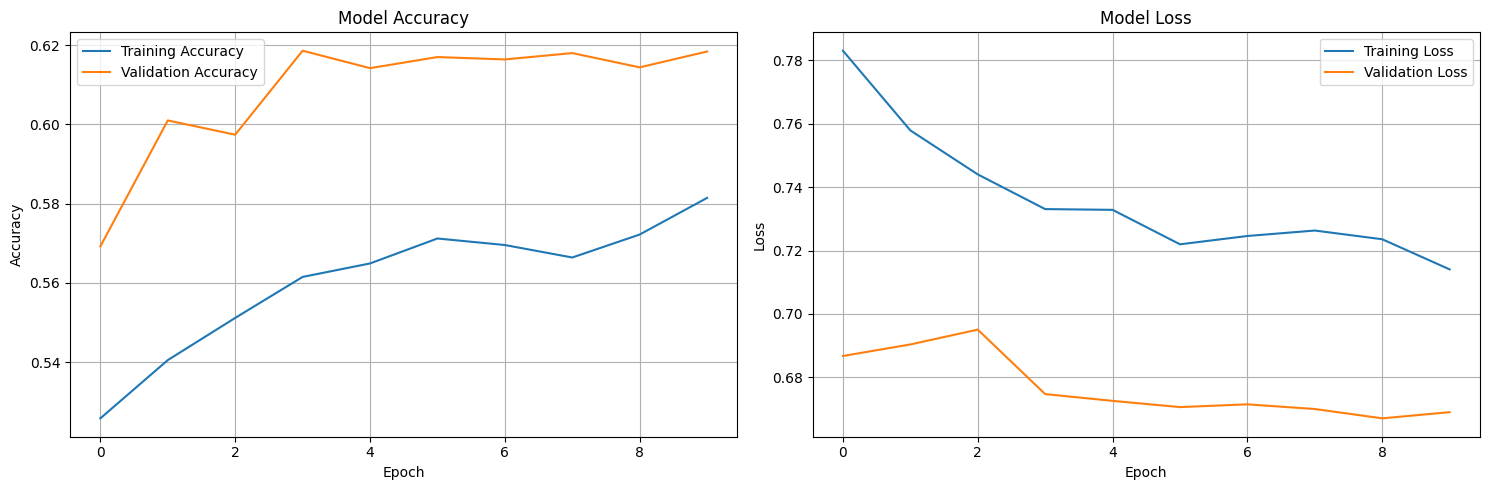

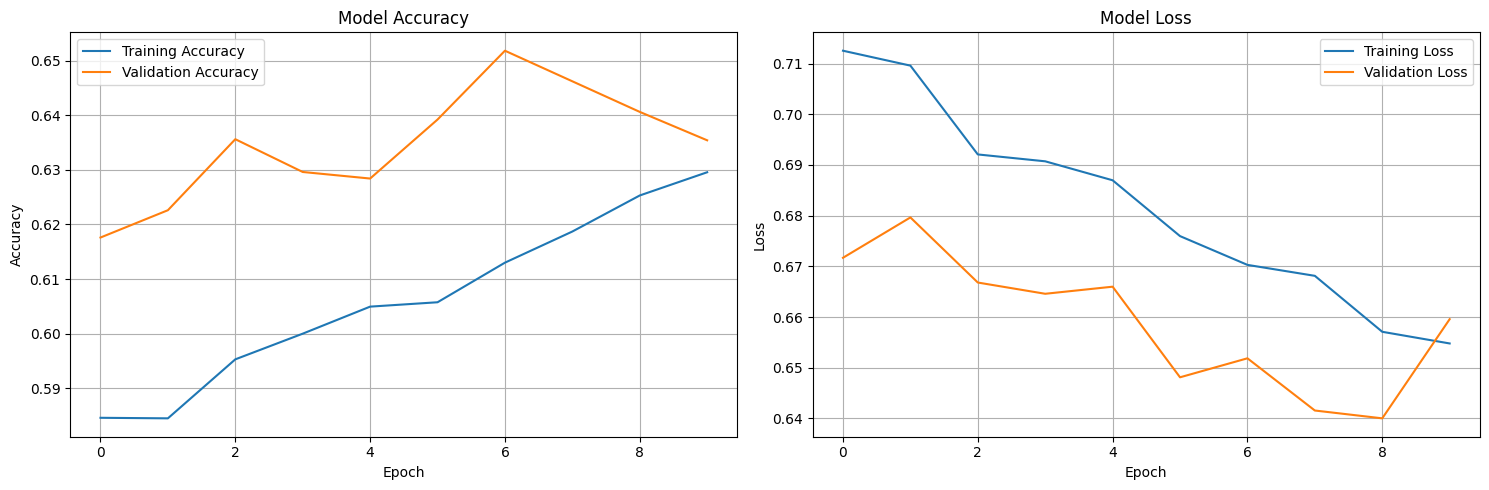

In [ ]:
plot_training_history(initial_history)
plot_training_history(fine_tune_history)